In [254]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Import Data

In [204]:
df = pd.read_csv("combined_df.csv")
df = df[
    (df['Year'] >= 2020) &
    (~(df['Headliner'].str.contains('"', na=False))) & 
    (df['Genre'] != 'Family Entertainment') &
    (df['Ticket Price Min USD'] > 0) &
    (df['Ticket Price Min USD'] < df['Ticket Price Max USD'])
]
df = df.dropna()
df['Event Date'] = pd.to_datetime(df['Event Date'], errors='coerce')
# Reset index after dropping rows
df = df.reset_index(drop=True)
df

/var/folders/5p/g82q05js0bs2xkv11dw5ksy80000gn/T/ipykernel_9584/1824778265.py:1: DtypeWarning: Columns (2,3,6,7,8,9,10,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("combined_df.csv")


,Event Date,Headliner,sp artist_name,sp artist_genre,sp followers,sp popularity,yt name,yt Channel ID,yt Title,yt Description,...,Genre,Avg. Tickets Sold,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min USD,Ticket Price Max USD,Ticket Price Avg. USD,Month,day_of_week
0,2024-09-18,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,20295.0,1228939.0,20295.0,100%,39.5,225.0,60.55,9,2
1,2024-09-14,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,16308.0,1374174.0,16308.0,100%,39.5,225.0,84.26,9,5
2,2024-09-13,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,14995.0,1402969.0,14995.0,100%,39.5,225.0,93.56,9,4
3,2024-09-11,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,19303.0,1512310.0,19303.0,100%,39.5,159.5,78.35,9,2
4,2024-09-10,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,10945.0,801952.0,10945.0,100%,39.5,159.5,73.27,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3356,2020-01-16,Ider,Ider,[],5.0,0.0,Ider,UCv8KgX89OA0yyPVAgoxx5lw,IDER,'Late To The World' OUT NOW! \n\nThe title tra...,...,Pop / Rock,227.0,3282.0,250.0,90%,15.0,100.0,14.46,1,3
3357,2020-01-16,Green Jelly,Green Jelly,"['comic metal', 'funk metal']",60041.0,35.0,Green Jelly,UCW8soHbDw-sZ8X2Cjb-2VcA,Green Jellÿ,Official Channel of Green Jello / Green Jelly\...,...,Pop / Rock,117.0,1260.0,200.0,58%,10.0,12.0,10.77,1,3
3358,2020-01-15,Grace Potter,Grace Potter,[],126207.0,55.0,Grace Potter,UChZPBtiR55itE778bGV3PlQ,Grace Potter,New album “Mother Road” out now: https://found...,...,Pop / Rock,852.0,36679.0,1868.0,45%,38.5,48.5,43.05,1,2
3359,2020-01-15,Caroline Polachek,Caroline Polachek,"['art pop', 'escape room', 'indie pop', 'indie...",542299.0,62.0,Caroline Polachek,UC_YiGpMGuBb1PbjqPQMf9MQ,Caroline Polachek,The official YouTube channel of Caroline Polachek,...,Pop / Rock,500.0,9250.0,500.0,100%,20.0,100.0,18.50,1,2


# Data Preprocessing

In [206]:
# Remove the after-concert data
columns_to_exclude = ['Avg. Tickets Sold', 'Avg. Capacity Sold', 'Ticket Price Avg. USD']
df = df.drop(columns=columns_to_exclude, errors='ignore')

# Extract time features from dates
df['Year'] = df['Event Date'].dt.year
df['Month'] = df['Event Date'].dt.month
df['Day'] = df['Event Date'].dt.day
df['Day_of_Week'] = df['Event Date'].dt.dayofweek
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3361 entries, 0 to 3360
Data columns (total 53 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Event Date                       3361 non-null   datetime64[ns]
 1   Headliner                        3361 non-null   object        
 2   sp artist_name                   3361 non-null   object        
 3   sp artist_genre                  3361 non-null   object        
 4   sp followers                     3361 non-null   float64       
 5   sp popularity                    3361 non-null   float64       
 6   yt name                          3361 non-null   object        
 7   yt Channel ID                    3361 non-null   object        
 8   yt Title                         3361 non-null   object        
 9   yt Description                   3361 non-null   object        
 10  yt Published At                  3361 non-null   object     

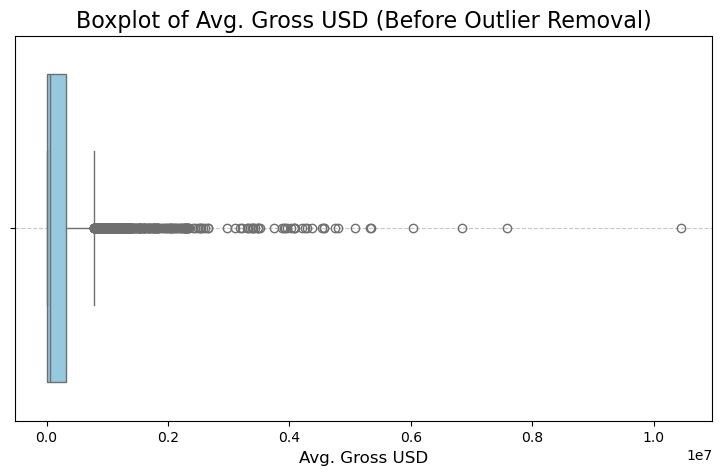

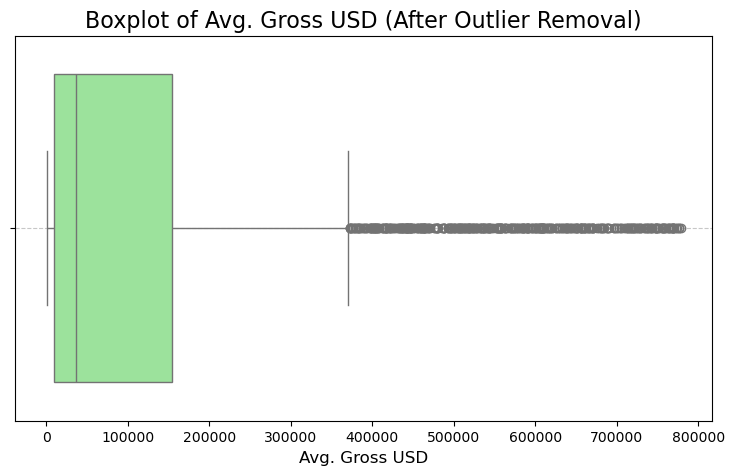

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot (before excluding outliers)
plt.figure(figsize=(9, 5))
sns.boxplot(x=df['Avg. Gross USD'], color='skyblue')
plt.title("Boxplot of Avg. Gross USD (Before Outlier Removal)", fontsize=16)
plt.xlabel("Avg. Gross USD", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calculate the IQR and remove the outliers
q1 = df['Avg. Gross USD'].quantile(0.25)
q3 = df['Avg. Gross USD'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_filtered = df[(df['Avg. Gross USD'] >= lower_bound) & (df['Avg. Gross USD'] <= upper_bound)]

# Boxplot (after excluding outliers)
plt.figure(figsize=(9, 5))
sns.boxplot(x=df_filtered['Avg. Gross USD'], color='lightgreen')
plt.title("Boxplot of Avg. Gross USD (After Outlier Removal)", fontsize=16)
plt.xlabel("Avg. Gross USD", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Exploratory Data Analysis

In [210]:
# Check statistic analysis for Avg. Gross USD
print("Descriptive Statistics for Avg. Gross USD:")
print(df['Avg. Gross USD'].describe())

# Filters numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation between numerical features and target variables
correlations = df[numeric_columns].corr()['Avg. Gross USD'].sort_values(ascending=False)
print("\nCorrelation of numerical features with Avg. Gross USD:")
print(correlations)

Descriptive Statistics for Avg. Gross USD:
count    3.361000e+03
mean     3.036503e+05
std      6.307795e+05
min      1.900000e+02
25%      1.075500e+04
50%      5.149550e+04
75%      3.179813e+05
max      1.044296e+07
Name: Avg. Gross USD, dtype: float64

Correlation of numerical features with Avg. Gross USD:
Avg. Gross USD                     1.000000
Avg. Event Capacity                0.816177
Ticket Price Max USD               0.584927
sp followers                       0.533951
monthly_listeners                  0.522213
headliner_monthly_listeners        0.522213
sp popularity                      0.456942
yt View Count                      0.427038
Ticket Price Min USD               0.412459
yt Subscriber Count                0.357633
yt Video Count                     0.094437
Number of Shows                    0.068983
10 to 14 years population          0.060112
5 to 9 years population            0.057795
55 to 59 years population          0.056746
15 to 19 years population   

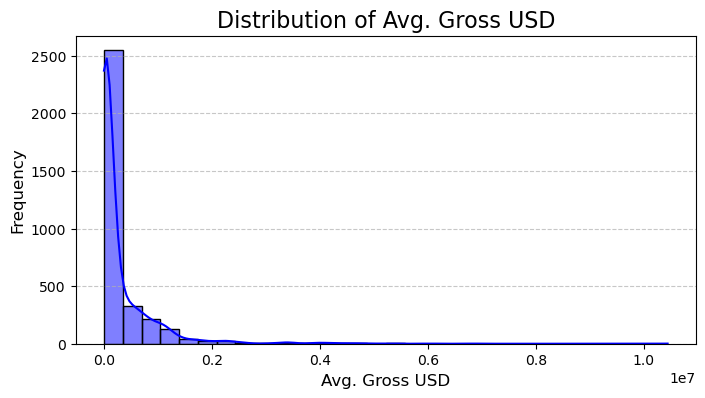

In [211]:
# 绘制目标变量分布图
plt.figure(figsize=(8, 4))
sns.histplot(df['Avg. Gross USD'], bins=30, kde=True, color='blue')
plt.title("Distribution of Avg. Gross USD", fontsize=16)
plt.xlabel("Avg. Gross USD", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


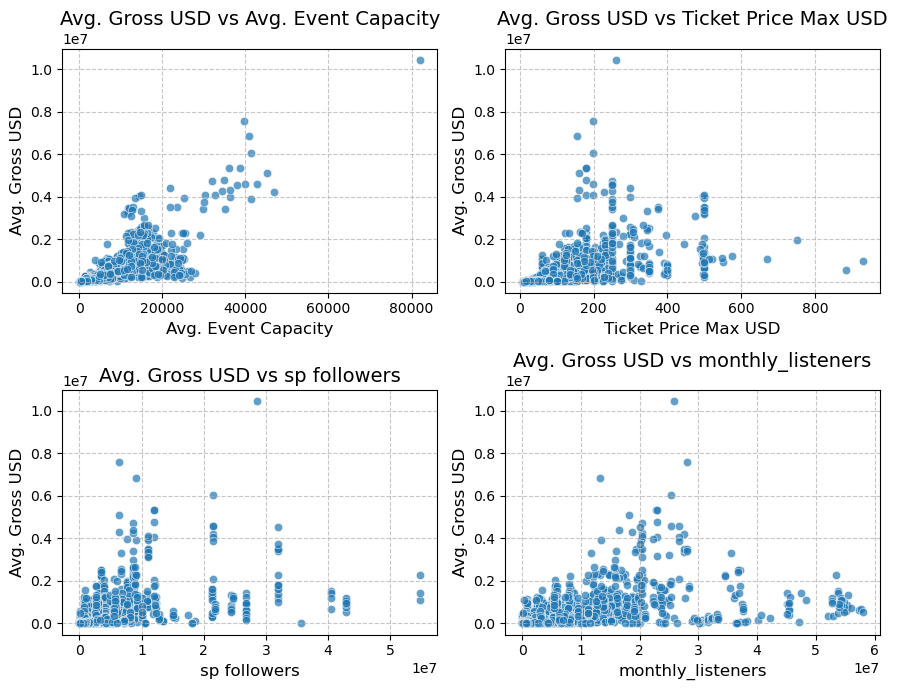

In [212]:
# Top 4 high scores feature related with Avg. Gross USD
features_to_plot = ['Avg. Event Capacity', 'Ticket Price Max USD', 'sp followers', 'monthly_listeners']

fig, axes = plt.subplots(2, 2, figsize=(9, 7))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.scatterplot(x=df[feature], y=df['Avg. Gross USD'], alpha=0.7, ax=axes[i])
    axes[i].set_title(f"Avg. Gross USD vs {feature}", fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel("Avg. Gross USD", fontsize=12)
    axes[i].grid(axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [213]:
print("Unique genres in the dataset:")
print(df['Genre'].unique())

print("\nDistribution of genres:")
print(df['Genre'].value_counts())
# Decrease data redundancy and model complexity
df = df.drop(columns=['Genre'], errors='ignore')

Unique genres in the dataset:
['Pop / Rock']

Distribution of genres:
Genre
Pop / Rock    3361
Name: count, dtype: int64


/var/folders/5p/g82q05js0bs2xkv11dw5ksy80000gn/T/ipykernel_9584/421059713.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['City'].isin(top_cities)], x='City', y='Avg. Gross USD', order=sorted_cities, palette='Set3')


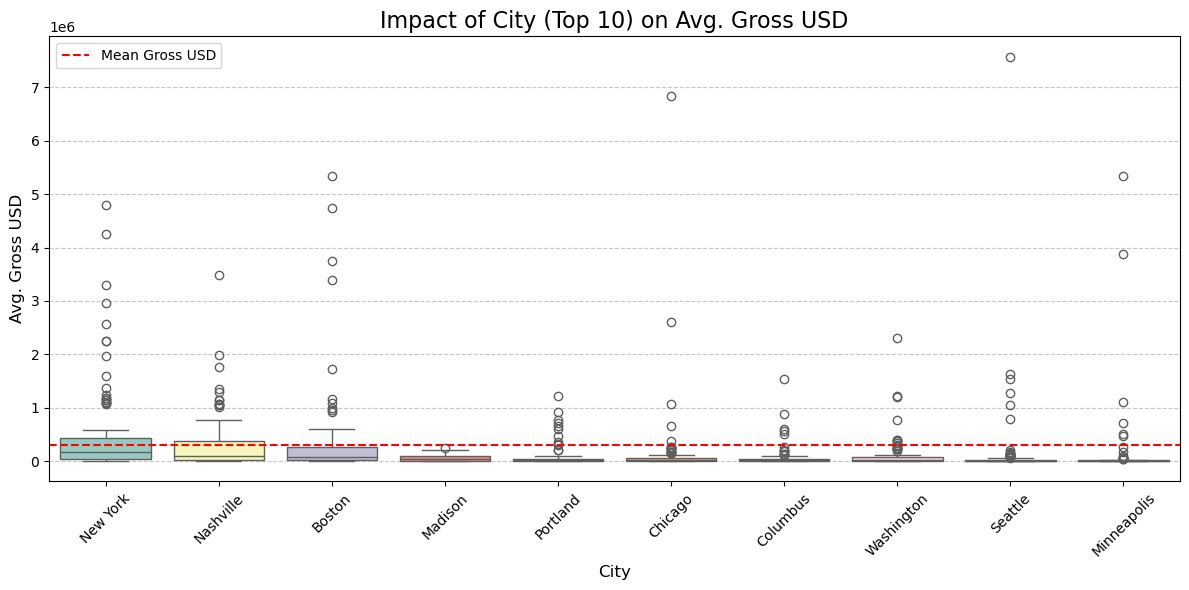

In [214]:
# Impact of City on Avg. Gross USD (Ranked by Median)
median_gross = df[df['City'].isin(top_cities)].groupby('City')['Avg. Gross USD'].median().sort_values(ascending=False)
sorted_cities = median_gross.index
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['City'].isin(top_cities)], x='City', y='Avg. Gross USD', order=sorted_cities, palette='Set3')

# Add a reference line
mean_gross = df['Avg. Gross USD'].mean()
plt.axhline(mean_gross, color='red', linestyle='--', linewidth=1.5, label='Mean Gross USD')

plt.title("Impact of City (Top 10) on Avg. Gross USD", fontsize=16)
plt.xlabel("City", fontsize=12)
plt.ylabel("Avg. Gross USD", fontsize=12)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Feature Engineer

In [227]:
# Extraction time feature
df['Year'] = df['Event Date'].dt.year
df['Month'] = df['Event Date'].dt.month
df['Day'] = df['Event Date'].dt.day
df['Day_of_Week'] = df['Event Date'].dt.dayofweek
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

print(df[['Event Date', 'Year', 'Month', 'Day', 'Day_of_Week', 'Is_Weekend']].head())

  Event Date  Year  Month  Day  Day_of_Week  Is_Weekend
0 2024-09-18  2024      9   18            2           0
1 2024-09-14  2024      9   14            5           1
2 2024-09-13  2024      9   13            4           0
3 2024-09-11  2024      9   11            2           0
4 2024-09-10  2024      9   10            1           0


In [231]:
# Initializes the target encoder
target_encoder = TargetEncoder()

# Target code the City column
df['City_encoded'] = target_encoder.fit_transform(df['City'], df['Avg. Gross USD'])
print(df[['City', 'City_encoded']].head())

            City   City_encoded
0        Raleigh  372286.315796
1  The Woodlands  498265.755355
2    San Antonio  392506.247703
3         Dallas  369553.384283
4         Rogers  359601.979344


In [233]:
# Generated interaction feature
df['Capacity_Ticket_Interaction'] = df['Avg. Event Capacity'] * df['Ticket Price Max USD']

print(df[['Avg. Event Capacity', 'Ticket Price Max USD', 'Capacity_Ticket_Interaction']].head())

   Avg. Event Capacity  Ticket Price Max USD  Capacity_Ticket_Interaction
0              20295.0                 225.0                    4566375.0
1              16308.0                 225.0                    3669300.0
2              14995.0                 225.0                    3373875.0
3              19303.0                 159.5                    3078828.5
4              10945.0                 159.5                    1745727.5


In [235]:
# Calculate city-level statistical features
city_stats = df.groupby('City')['Avg. Gross USD'].agg(['mean', 'median']).reset_index()
city_stats.rename(columns={'mean': 'City_Avg_Gross_Mean', 'median': 'City_Avg_Gross_Median'}, inplace=True)

# Merge statistical features into original data
df = df.merge(city_stats, on='City', how='left')

print(df[['City', 'City_Avg_Gross_Mean', 'City_Avg_Gross_Median']].head())

            City  City_Avg_Gross_Mean  City_Avg_Gross_Median
0        Raleigh        464935.294118             404537.000
1  The Woodlands        890173.226923             948704.000
2    San Antonio        590258.875000              30310.125
3         Dallas        389403.022500              80448.000
4         Rogers        511694.509000             550708.000


In [239]:
# Filter numrical columns (correlation analysis)
numeric_columns = df.select_dtypes(include=['float64', 'int64'])
correlation_with_target = numeric_columns.corr()['Avg. Gross USD'].sort_values(ascending=False)

# Sort correlation
print("\nCorrelation with Avg. Gross USD:")
print(correlation_with_target)

# Filter features by relevance (threshold: 0.1)
selected_features = correlation_with_target[correlation_with_target > 0.1].index.tolist()
df_selected = df[selected_features]

print("\nSelected Features:")
print(df_selected.head())


Correlation with Avg. Gross USD:
Avg. Gross USD                     1.000000
Avg. Event Capacity                0.816177
Capacity_Ticket_Interaction        0.771636
Ticket Price Max USD               0.584927
City_Avg_Gross_Mean                0.569458
sp followers                       0.533951
City_Avg_Gross_Median              0.526788
headliner_monthly_listeners        0.522213
monthly_listeners                  0.522213
sp popularity                      0.456942
City_encoded                       0.435316
yt View Count                      0.427038
Ticket Price Min USD               0.412459
yt Subscriber Count                0.357633
yt Video Count                     0.094437
Number of Shows                    0.068983
10 to 14 years population          0.060112
5 to 9 years population            0.057795
55 to 59 years population          0.056746
15 to 19 years population          0.056139
45 to 54 years population          0.055123
Under 5 years population           0.05442

In [247]:
# Filter features based on correlation (threshold: 0.5)
selected_features = correlation_with_target[correlation_with_target > 0.5].index.tolist()

# Remove non-used feature
selected_features = [feature for feature in selected_features if feature != 'Support_Total_Monthly_Listeners']

# Filtered data set
df_selected = df[selected_features]

print("\nSelected Features for Modeling:")
print(list(df_selected))


Selected Features for Modeling:
['Avg. Gross USD', 'Avg. Event Capacity', 'Capacity_Ticket_Interaction', 'Ticket Price Max USD', 'City_Avg_Gross_Mean', 'sp followers', 'City_Avg_Gross_Median', 'headliner_monthly_listeners', 'monthly_listeners']


# Training Models

In [256]:
# Define features and target variable
X = df[['Avg. Event Capacity', 'Capacity_Ticket_Interaction', 'Ticket Price Max USD', 
        'City_Avg_Gross_Mean', 'sp followers', 'City_Avg_Gross_Median', 
        'headliner_monthly_listeners', 'monthly_listeners']]
y = df['Avg. Gross USD']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

Training set size: (2688, 8), Test set size: (673, 8)


In [262]:
# Linear Regression
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.2f}")

MAE: 168382.01
RMSE: 357494.38
R^2: 0.64


In [264]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R^2: {r2_rf:.2f}")

MAE: 69477.85
RMSE: 175919.31
R^2: 0.91


In [266]:
# XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R^2: {r2_xgb:.2f}")

MAE: 72392.87
RMSE: 173137.52
R^2: 0.92


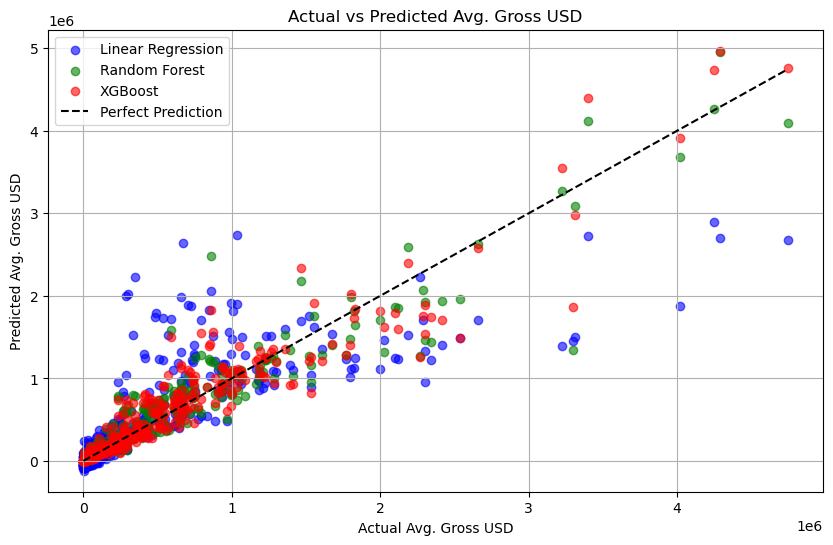

In [268]:
import matplotlib.pyplot as plt

# actual value against the predicted value
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Linear Regression', color='blue')
plt.scatter(y_test, y_pred_rf, alpha=0.6, label='Random Forest', color='green')
plt.scatter(y_test, y_pred_xgb, alpha=0.6, label='XGBoost', color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='black', label='Perfect Prediction')
plt.xlabel('Actual Avg. Gross USD')
plt.ylabel('Predicted Avg. Gross USD')
plt.title('Actual vs Predicted Avg. Gross USD')
plt.legend()
plt.grid()
plt.show()

In [41]:
list(df)

['Event Date',
 'sp followers',
 'sp popularity',
 'yt name',
 'yt Channel ID',
 'yt Title',
 'yt Description',
 'yt Published At',
 'yt View Count',
 'yt Subscriber Count',
 'yt Video Count',
 'Total population',
 'Under 5 years population',
 '5 to 9 years population',
 '10 to 14 years population',
 '15 to 19 years population',
 '20 to 24 years population',
 '25 to 34 years population',
 '35 to 44 years population',
 '45 to 54 years population',
 '55 to 59 years population',
 '60 to 64 years population',
 '65 to 74 years population',
 '75 to 84 years population',
 '85 years and over population',
 'Median age',
 'Year',
 'headliner_monthly_listeners',
 'Support_Total_Monthly_Listeners',
 'monthly_listeners',
 'Number of Shows',
 'Support',
 'Venue',
 'Company Type',
 'Currency',
 'Promoter',
 'Avg. Gross USD',
 'Avg. Event Capacity',
 'Ticket Price Min USD',
 'Ticket Price Max USD',
 'Month',
 'day_of_week',
 'Headliner_Fit For An Autopsy',
 'Headliner_Goth Babe',
 'Headliner_Greta Van